In [ ]:
import os
from flask import Flask, render_template
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
app = Flask(__name__)
# VGG16
from keras.applications.vgg16 import VGG16

# To show images
from PIL import Image

# Create Functions

#### Create data frame

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Collect all data into one dataframe
def create_df(dataset):
    image_paths, labels = [], []

    for dirpath, dirnames, filenames in os.walk(dataset):
        for filename in filenames:

            image = os.path.join(dirpath, filename)
            image_paths.append(image)
            if dirpath[-3:] == 'all':
                labels.append('all')
            else:
                labels.append('hem')

    df = pd.DataFrame({'Image Path': image_paths,
                           'Label': labels})

    return df


train_dir = "/content/drive/MyDrive/Leukemia_Cancer/data/training_data"
df =  create_df(train_dir)

train_df, remaining_df = train_test_split(df, train_size=0.7, shuffle=True, random_state=31, stratify=df['Label'])
valid_df, test_df= train_test_split(remaining_df, train_size=0.5, shuffle=True, random_state=31, stratify=remaining_df['Label'])

print("Number of training samples: %d" % len(train_df.index))
print("Number of test samples: %d" % len(test_df.index))
print("Number of validation samples: %d" % len(valid_df.index))

Number of training samples: 7462
Number of test samples: 1600
Number of validation samples: 1599


#### Display Model Performance

In [ ]:
def show_history_plot(history):

    training_accuracy = history['accuracy']
    epochs = range(1, len(training_accuracy) + 1)

    # Creating subplots for accuracy and loss
    plt.figure(figsize=(15, 5))

    # Plotting training and validation accuracy
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
    plt.plot(epochs, history['accuracy'], 'b', label='Training accuracy', marker='o')
    plt.plot(epochs, history['val_accuracy'], 'c', label='Validation accuracy', marker='o')
    plt.title('Training and Validation Accuracy', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend()
    plt.grid(True)

    # Plotting training and validation loss
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
    plt.plot(epochs, history['loss'], 'b', label='Training loss', marker='o')
    plt.plot(epochs, history['val_loss'], 'c', label='Validation loss', marker='o')
    plt.title('Training and Validation Loss', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.grid(True)

    # Improve layout and displaying the plot
    plt.tight_layout()
    plt.show()

In [ ]:
import urllib2
import mako
from bs4 import BeautifulSoup as BS

html = urllib2.urlopen("major.html")
soup = BS(html)
data = []


for each_course in soup.findAll('li',{'class':'op'}):
    inner_text = each_course.text
    data.append(inner_text)


for i in data:
    print (i+"\n")

#### Confusion Matrix

In [ ]:
def show_conf_matrix(model):
    test_gen.reset()  # Reset the generator to be sure it's at the start of the dataset
    y_pred = model.predict(test_gen, steps=test_gen.n // test_gen.batch_size+1, verbose=0)

    label_dict = test_gen.class_indices
    classes = list(label_dict.keys())

    # Convert predictions to labels
    pred_labels = np.argmax(y_pred, axis=1)
    y_true = test_gen.classes

    # Generate the confusion matrix
    confusion_matrix = metrics.confusion_matrix(y_true, pred_labels)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[True, False])

    # Plot the confusion matrix
    cmap = plt.cm.Blues
    cm_display.plot(cmap=cmap, colorbar=False)

    plt.title('Confusion Matrix', fontsize=16)
    plt.figure(figsize=(7, 7))
    plt.show()

#### Evaluation Matrix

In [ ]:
def evaluation_matrix(model):
    test_steps = len(test_df) // batch_size
    train_score = model.evaluate(train_gen, steps= test_steps, verbose= 0)
    valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 0)
    test_score = model.evaluate(test_gen, steps= test_steps, verbose= 0)

    header = "{:<12} {:<10} {:<10}".format("", "Loss", "Accuracy")
    separator = '-' * len(header)
    train_row = "{:<12} {:<10.5f} {:<10.5f}".format("Train", train_score[0], train_score[1])  # Formats the float to five decimal places
    valid_row = "{:<12} {:<10.5f} {:<10.5f}".format("Validation", valid_score[0], valid_score[1])
    test_row = "{:<12} {:<10.5f} {:<10.5f}".format("Test", test_score[0], test_score[1])

    table = '\n'.join([header, separator, train_row, valid_row, test_row])
    print(table)

#### Show Images

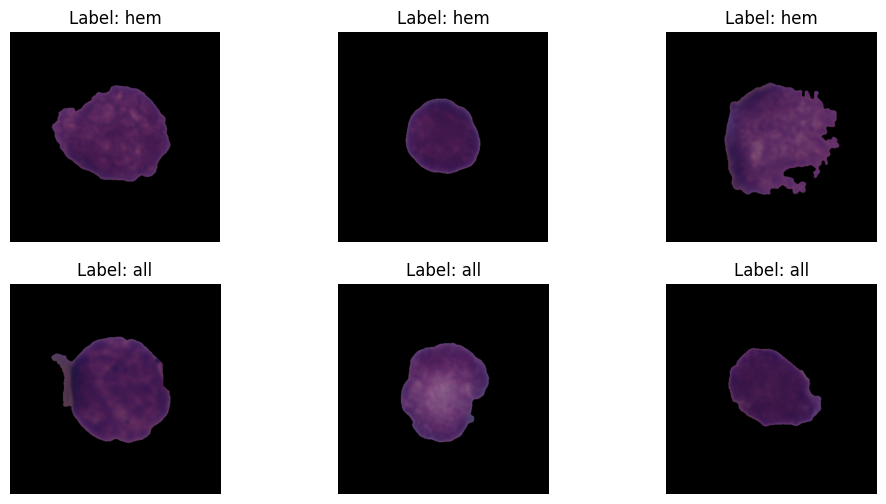

In [ ]:
hem_img = train_df[train_df['Label'] == 'hem'].sample(3)
all_img = train_df[train_df['Label'] == 'all'].sample(3)
sampled_df = pd.concat([hem_img, all_img])

# Create a figure with subplots to show the images in
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))

for i, row in enumerate(sampled_df.iterrows()):
    img = mpimg.imread(row[1]['Image Path'])
    ax = axes[i//3, i%3]
    ax.imshow(img)
    ax.axis('off')
    if row[1]['Label'] == 'hem':
        ax.set_title(f"Label: hem")
    else:
        ax.set_title(f"Label: all")

plt.show()

#### Initializing Image Data Generators

In [ ]:
batch_size = 40

train_data_generator = ImageDataGenerator(horizontal_flip=True)
valid_data_generator = ImageDataGenerator()

train_gen = train_data_generator.flow_from_dataframe( train_df, x_col= 'Image Path', y_col= 'Label', target_size= (224, 224), class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = valid_data_generator.flow_from_dataframe( valid_df, x_col= 'Image Path', y_col= 'Label', target_size= (224, 224), class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = valid_data_generator.flow_from_dataframe( test_df, x_col= 'Image Path', y_col= 'Label', target_size= (224, 224), class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

train_steps = test_gen.n // test_gen.batch_size + 1
validation_steps = valid_gen.n // valid_gen.batch_size

Found 7462 validated image filenames belonging to 2 classes.
Found 1599 validated image filenames belonging to 2 classes.
Found 1600 validated image filenames belonging to 2 classes.


# Classification Models

## VGG16

In [ ]:
# Instantiate base model
img_shape=(224, 224, 3)
VGG16_base_model = VGG16(weights='imagenet', input_shape=img_shape, include_top=False, pooling=None)

# Freeze base model to keep pre-trained weights
VGG16_base_model.trainable = False

# Add custom top layers for binary classification
last_layer = VGG16_base_model.get_layer('block5_pool')
last_output = last_layer.output
x = keras.layers.GlobalMaxPooling2D()(last_output)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(2, activation='sigmoid')(x)

# Create new model
VGG16_model = tf.keras.Model(VGG16_base_model.input, x, name="VGG16_model")

VGG16_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

VGG16_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "VGG16_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                        

#### Train Model

In [ ]:
epochs = 5

history_VGG16 = VGG16_model.fit(
    train_gen,
    steps_per_epoch=train_steps,
    validation_data=valid_gen,
    validation_steps=validation_steps,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

Epoch 1/5
41/41 [==============================] - 798s 19s/step - loss: 7.4052 - accuracy: 0.5933 - val_loss: 2.8248 - val_accuracy: 0.7006
Epoch 2/5
41/41 [==============================] - 302s 7s/step - loss: 5.6768 - accuracy: 0.6177 - val_loss: 1.9376 - val_accuracy: 0.7340
Epoch 3/5
41/41 [==============================] - 242s 6s/step - loss: 5.1594 - accuracy: 0.6299 - val_loss: 1.7856 - val_accuracy: 0.7481
Epoch 4/5
41/41 [==============================] - 192s 5s/step - loss: 3.9889 - accuracy: 0.6535 - val_loss: 1.9387 - val_accuracy: 0.7737
Epoch 5/5
41/41 [==============================] - 150s 4s/step - loss: 3.8891 - accuracy: 0.6823 - val_loss: 1.6802 - val_accuracy: 0.7833


#### Evaluate Model

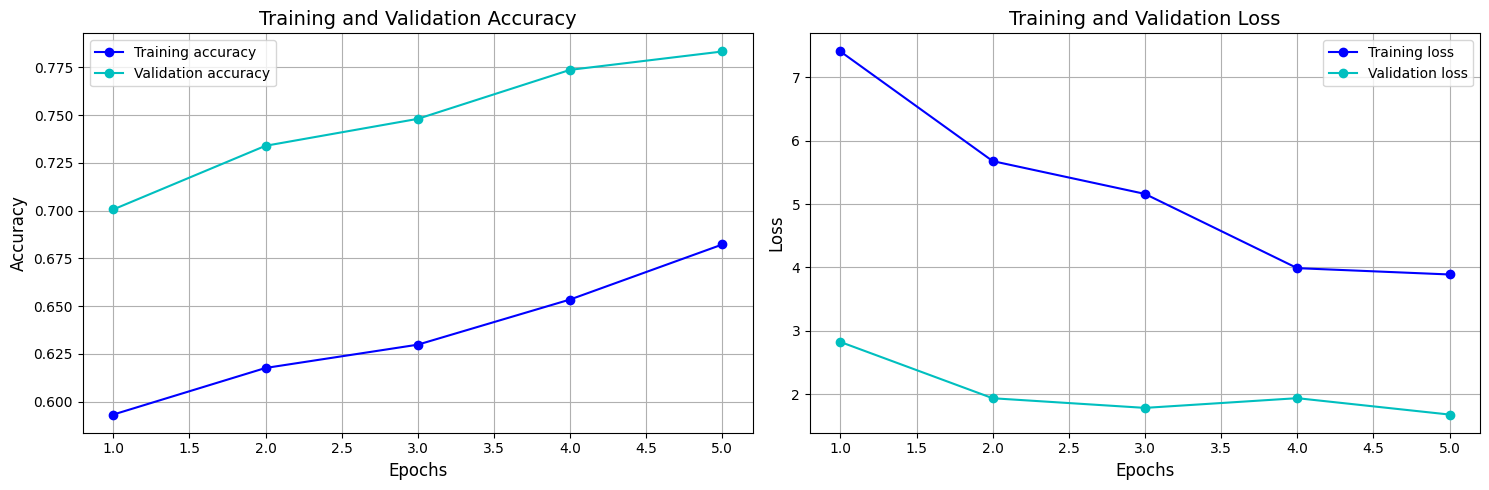

In [ ]:
show_history_plot(history_VGG16.history)

In [ ]:
evaluation_matrix(VGG16_model)

             Loss       Accuracy  
----------------------------------
Train        1.74561    0.77125   
Validation   1.66578    0.78487   
Test         1.65704    0.77125   


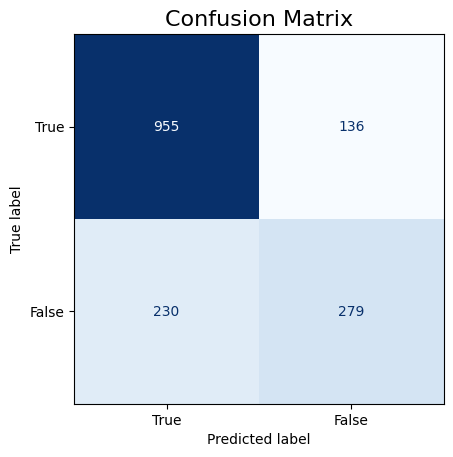

<Figure size 700x700 with 0 Axes>

In [ ]:
show_conf_matrix(VGG16_model)

In [ ]:
final_validation_accuracy = history_VGG16.history['val_accuracy'][-1]
def index(final_validation_accuracy ):
    # Calculate accuracy
  

    # Render HTML template with accuracy
    return render_template('index.html', accuracy=final_validation_accuracy )

if __name__ == '__main__':
    app.run(debug=True)

## EfficientNet

In [ ]:
# Create Model Structure
img_shape = (224, 224, 3)
EN3_base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

EN3_model = Sequential([
    EN3_base_model,
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.45),
    Dense(2, activation='softmax')
])

# Compile the model
EN3_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

EN3_model.summary()

43941136/43941136 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                         

#### Train Model

In [ ]:
epochs = 5

history_EN3 = EN3_model.fit(x= train_gen, epochs= epochs, verbose= 1,
                    validation_data= valid_gen, validation_steps= None, shuffle= False)

Epoch 1/5
187/187 [==============================] - 3973s 21s/step - loss: 0.6253 - accuracy: 0.8018 - val_loss: 0.4893 - val_accuracy: 0.8061
Epoch 2/5
187/187 [==============================] - 138s 736ms/step - loss: 0.3600 - accuracy: 0.8709 - val_loss: 0.3609 - val_accuracy: 0.8799
Epoch 3/5
187/187 [==============================] - 138s 737ms/step - loss: 0.2472 - accuracy: 0.9054 - val_loss: 0.3107 - val_accuracy: 0.8962
Epoch 4/5
187/187 [==============================] - 132s 703ms/step - loss: 0.1945 - accuracy: 0.9240 - val_loss: 0.3024 - val_accuracy: 0.8974
Epoch 5/5
187/187 [==============================] - 130s 695ms/step - loss: 0.1824 - accuracy: 0.9321 - val_loss: 0.4377 - val_accuracy: 0.8874


#### Evaluate Model

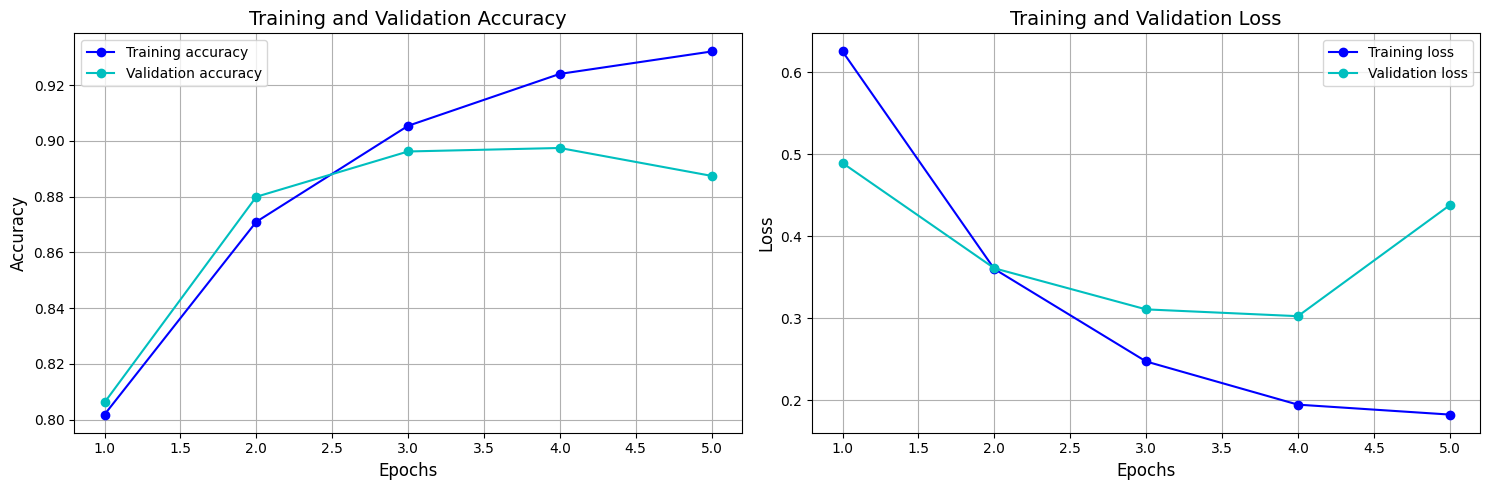

In [ ]:
show_history_plot(history_EN3.history)

In [ ]:
evaluation_matrix(EN3_model)

             Loss       Accuracy  
----------------------------------
Train        0.37118    0.87563   
Validation   0.43773    0.88743   
Test         0.52817    0.85188   


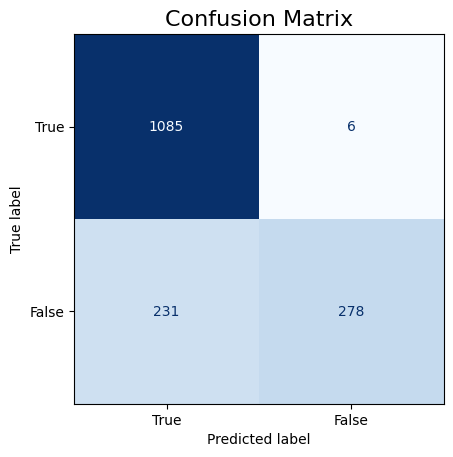

<Figure size 700x700 with 0 Axes>

In [ ]:
show_conf_matrix(EN3_model)

In [ ]:
final_validation_accuracy = history_EN3.history['val_accuracy'][-1]
def index(final_validation_accuracy):
    # Calculate accuracy


    # Render HTML template with accuracy
    return render_template('1.html', accuracy=final_validation_accuracy)

if __name__ == '__main__':
    app.run(debug=True)

## LeNet

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.losses import categorical_crossentropy

# Define the LeNet model architecture
LeNet_model = Sequential([
    Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(16, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(120, activation='relu'),
    Dense(84, activation='relu'),
    Dense(2, activation='softmax')
])

# Compile the LeNet model
LeNet_model.compile(optimizer=Adamax(learning_rate=0.001),
                    loss=categorical_crossentropy,
                    metrics=['accuracy'])


LeNet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 6)       456       
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 16)      2416      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 16)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 44944)             0         
                                                                 
 dense (Dense)               (None, 120)               5

#### Train the Model

In [ ]:
# Train the LeNet model
epochs = 5

history_LeNet = LeNet_model.fit(train_gen,
                                steps_per_epoch=train_steps,
                                validation_data=valid_gen,
                                validation_steps=validation_steps,
                                epochs=epochs,
                                verbose=1)

Epoch 1/5
50/50 [==============================] - 281s 5s/step - loss: 2.4931 - accuracy: 0.8345 - val_loss: 4.7818 - val_accuracy: 0.7531
Epoch 2/5
50/50 [==============================] - 265s 5s/step - loss: 1.4390 - accuracy: 0.8613 - val_loss: 2.0308 - val_accuracy: 0.7456
Epoch 3/5
50/50 [==============================] - 263s 5s/step - loss: 1.1045 - accuracy: 0.8926 - val_loss: 2.6532 - val_accuracy: 0.7488
Epoch 4/5
50/50 [==============================] - 266s 5s/step - loss: 1.1252 - accuracy: 0.9014 - val_loss: 2.0084 - val_accuracy: 0.7338
Epoch 5/5
50/50 [==============================] - 263s 5s/step - loss: 0.9464 - accuracy: 0.8821 - val_loss: 2.3812 - val_accuracy: 0.7550


#### Evaluate Model

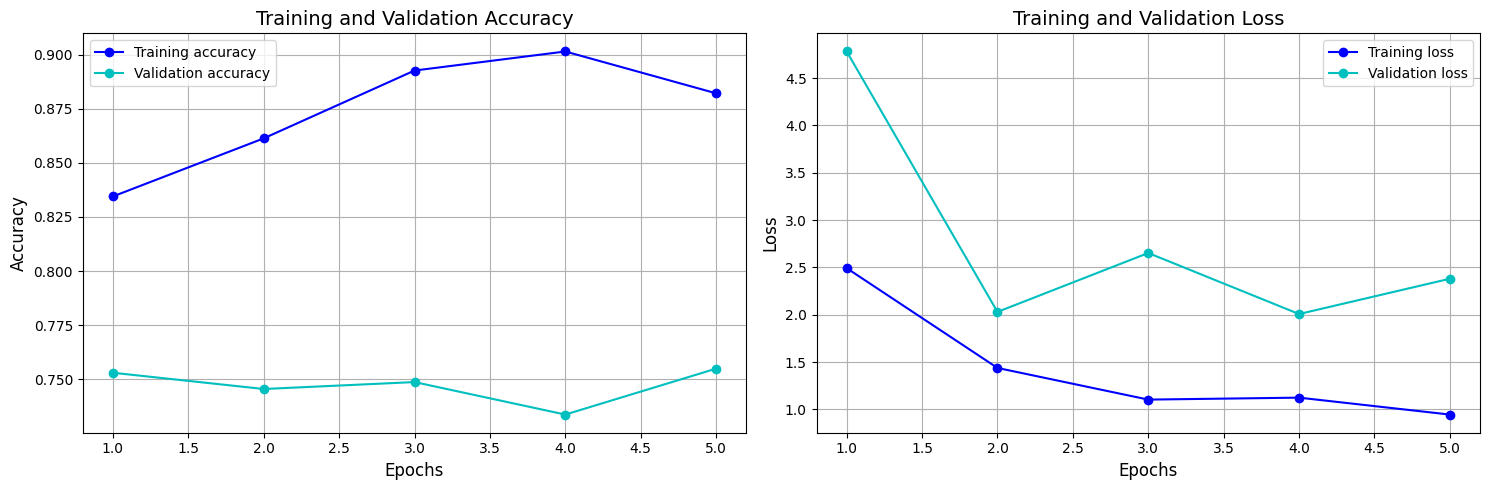

In [ ]:
show_history_plot(history_LeNet.history)

In [ ]:
evaluation_matrix(LeNet_model)

             Loss       Accuracy 
----------------------------------
Train        0.94645    0.88216   
Validation   0.38123    0.75507   
Test         0.66389    0.83588   


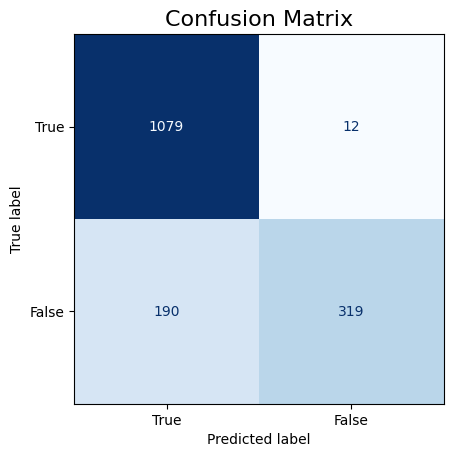

<Figure size 700x700 with 0 Axes>

In [ ]:
show_conf_matrix(LeNet_model)

In [ ]:
final_validation_accuracy = history_LeNet.history['val_accuracy'][-1]

def index():
    # Calculate accuracy
   

    # Render HTML template with accuracy
    return render_template('1.html', accuracy=final_validation_accuracy)

if __name__ == '__main__':
    app.run(debug=True)

## AlexNet

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.losses import categorical_crossentropy

# Define the AlexNet model architecture
AlexNet_model = Sequential([
    Conv2D(96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    Conv2D(256, kernel_size=(5, 5), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

# Compile the AlexNet model
AlexNet_model.compile(optimizer=Adamax(learning_rate=0.001),
                      loss=categorical_crossentropy,
                      metrics=['accuracy'])

# Print model summary
AlexNet_model.summary()



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 26, 26, 96)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 26, 26, 256)       614656    
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 12, 12, 256)       0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 12, 12, 384)       885120    
                                                                 
 conv2d_13 (Conv2D)          (None, 12, 12, 384)      

#### Train the Model

In [ ]:
history_AlexNet = AlexNet_model.fit(train_gen,
                                    steps_per_epoch=train_steps,
                                    validation_data=valid_gen,
                                    validation_steps=validation_steps,
                                    epochs=epochs,
                                    verbose=1)

Epoch 1/5
50/50 [==============================] - 90s 2s/step - loss: 2.1986 - accuracy: 0.7667 - val_loss: 4.4861 - val_accuracy: 0.6462
Epoch 2/5
50/50 [==============================] - 87s 2s/step - loss: 1.2855 - accuracy: 0.8026 - val_loss: 4.0455 - val_accuracy: 0.6619
Epoch 3/5
50/50 [==============================] - 87s 2s/step - loss: 0.6922 - accuracy: 0.8880 - val_loss: 2.4397 - val_accuracy: 0.7525
Epoch 4/5
50/50 [==============================] - 87s 2s/step - loss: 0.2936 - accuracy: 0.8787 - val_loss: 1.6780 - val_accuracy: 0.7544
Epoch 5/5
50/50 [==============================] - 87s 2s/step - loss: 0.0371 - accuracy: 0.9019 - val_loss: 0.9595 - val_accuracy: 0.7581


#### Evaluate the Model

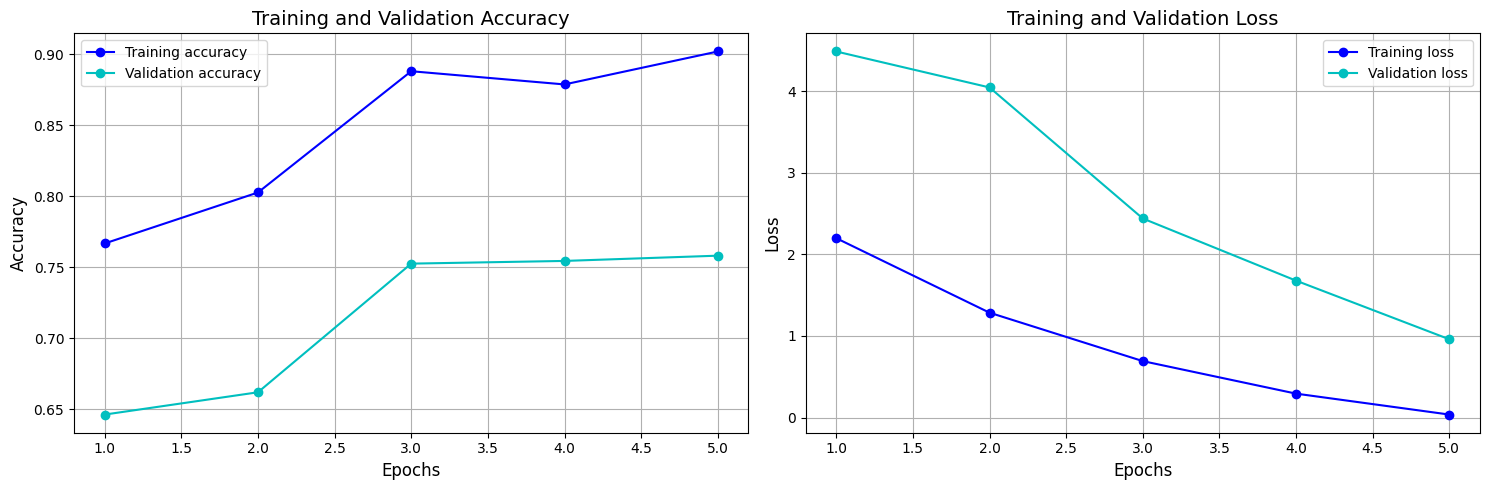

In [ ]:
show_history_plot(history_AlexNet.history)

In [ ]:
evaluation_matrix(AlexNet_model)

             Loss       Accuracy 
----------------------------------
Train        0.22023    0.90926   
Validation   0.41579    0.79356   
Test         0.33952    0.88975   


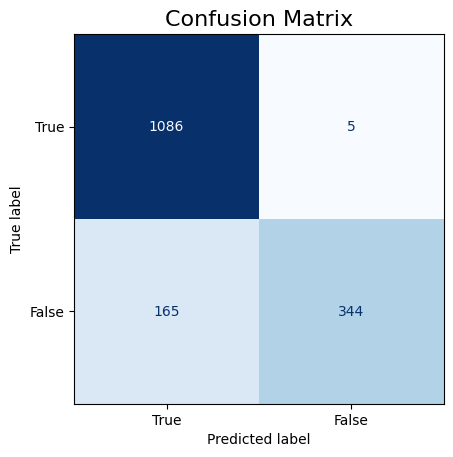

<Figure size 700x700 with 0 Axes>

In [ ]:
show_conf_matrix(AlexNet_model)

In [ ]:
final_validation_accuracy = history_AlexNet.history['val_accuracy'][-1]

def index(final_validation_accuracy ):
    # Calculate accuracy


    # Render HTML template with accuracy
    return render_template('1.html', accuracy=final_validation_accuracy )

if __name__ == '__main__':
    app.run(debug=True)

## CNN

In [ ]:
CNN_model = Sequential()
CNN_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model.add(Conv2D(64, (3, 3), activation='relu'))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model.add(Flatten())
CNN_model.add(Dense(64, activation='relu'))
CNN_model.add(Dropout(0.2))
CNN_model.add(Dense(2, activation='softmax'))

CNN_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
CNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 186624)            0         
                                                                 
 dense_2 (Dense)             (None, 64)               

#### Train the Model

In [ ]:
history_CNN = CNN_model.fit(train_gen, epochs=5, validation_data=valid_gen)

Epoch 1/5
187/187 [==============================] - 2231s 12s/step - loss: 4.5747 - accuracy: 0.7824 - val_loss: 0.4386 - val_accuracy: 0.8105
Epoch 2/5
187/187 [==============================] - 87s 467ms/step - loss: 0.4323 - accuracy: 0.8159 - val_loss: 0.4367 - val_accuracy: 0.8274
Epoch 3/5
187/187 [==============================] - 84s 450ms/step - loss: 0.3844 - accuracy: 0.8332 - val_loss: 0.4043 - val_accuracy: 0.8399
Epoch 4/5
187/187 [==============================] - 91s 487ms/step - loss: 0.3439 - accuracy: 0.8562 - val_loss: 0.4068 - val_accuracy: 0.8368
Epoch 5/5
187/187 [==============================] - 83s 443ms/step - loss: 0.2986 - accuracy: 0.8747 - val_loss: 0.4340 - val_accuracy: 0.8293


#### Evaluate the Model

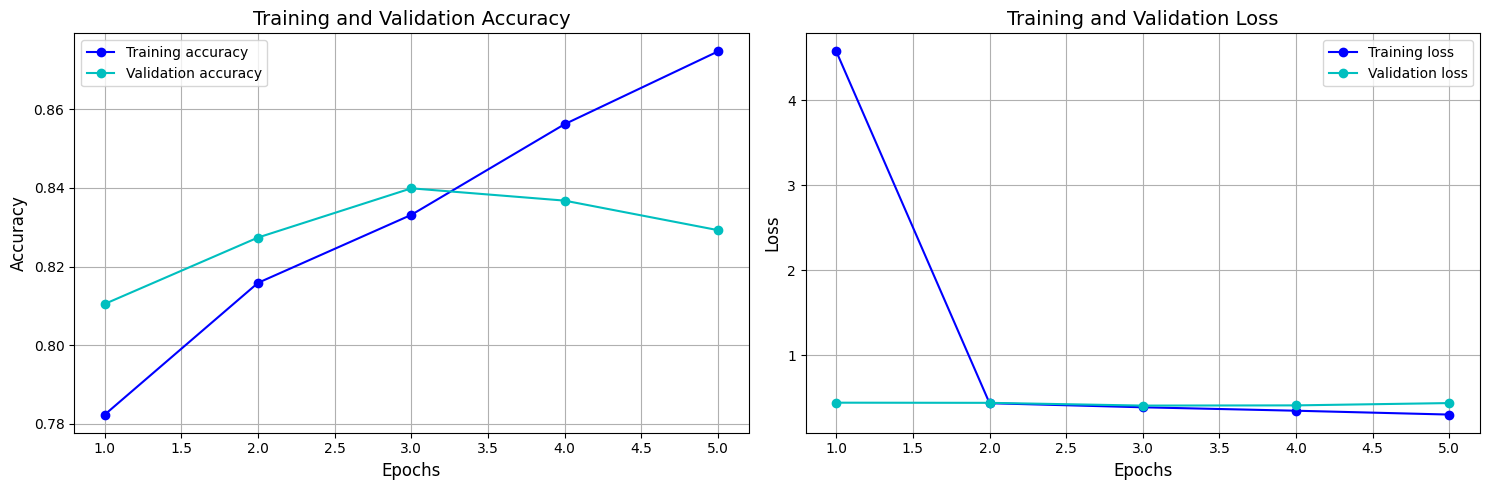

In [ ]:
show_history_plot(history_CNN.history)

In [ ]:
evaluation_matrix(CNN_model)

             Loss       Accuracy  
----------------------------------
Train        0.23578    0.90625   
Validation   0.43400    0.82927   
Test         0.48847    0.81375   


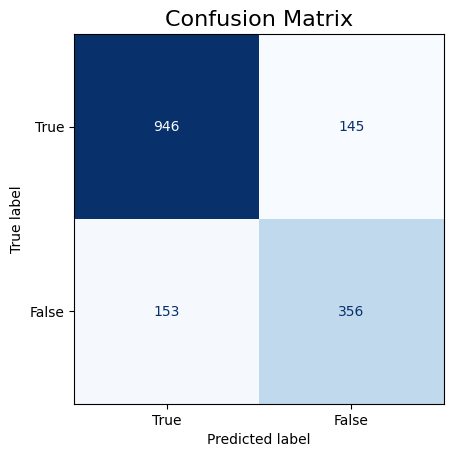

<Figure size 700x700 with 0 Axes>

In [ ]:
show_conf_matrix(CNN_model)

In [ ]:
final_validation_accuracy = history_CNN.history['val_accuracy'][-1]

def index(final_validation_accuracy ):
    # Calculate accuracy
  

    # Render HTML template with accuracy
    return render_template('1.html', accuracy=final_validation_accuracy)

if __name__ == '__main__':
    app.run(debug=True)

## ResNet

In [ ]:
# Import the ResNet50 model
from keras.applications import ResNet50
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dropout

# Load pre-trained ResNet50 model without the top layer (include_top=False)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)  # 2 classes: 'all' and 'hem'

# Create the final model
ResNet_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
ResNet_model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
ResNet_model.summary()

94765736/94765736 [==============================] - 1s 0us/step


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

#### Train the Model

In [ ]:
# Train the model
history_ResNet = ResNet_model.fit(train_gen,
                    steps_per_epoch=train_steps,
                    validation_data=valid_gen,
                    validation_steps=validation_steps,
                    epochs=5)

Epoch 1/5
41/41 [==============================] - 49s 962ms/step - loss: 0.8721 - accuracy: 0.6787 - val_loss: 0.4564 - val_accuracy: 0.8032
Epoch 2/5
41/41 [==============================] - 39s 952ms/step - loss: 0.5062 - accuracy: 0.7836 - val_loss: 0.4511 - val_accuracy: 0.8173
Epoch 3/5
41/41 [==============================] - 26s 632ms/step - loss: 0.4720 - accuracy: 0.8018 - val_loss: 0.4255 - val_accuracy: 0.8288
Epoch 4/5
41/41 [==============================] - 27s 671ms/step - loss: 0.4658 - accuracy: 0.7994 - val_loss: 0.4247 - val_accuracy: 0.8237
Epoch 5/5
41/41 [==============================] - 35s 862ms/step - loss: 0.4513 - accuracy: 0.8126 - val_loss: 0.4139 - val_accuracy: 0.8263


#### Evaluate the Model

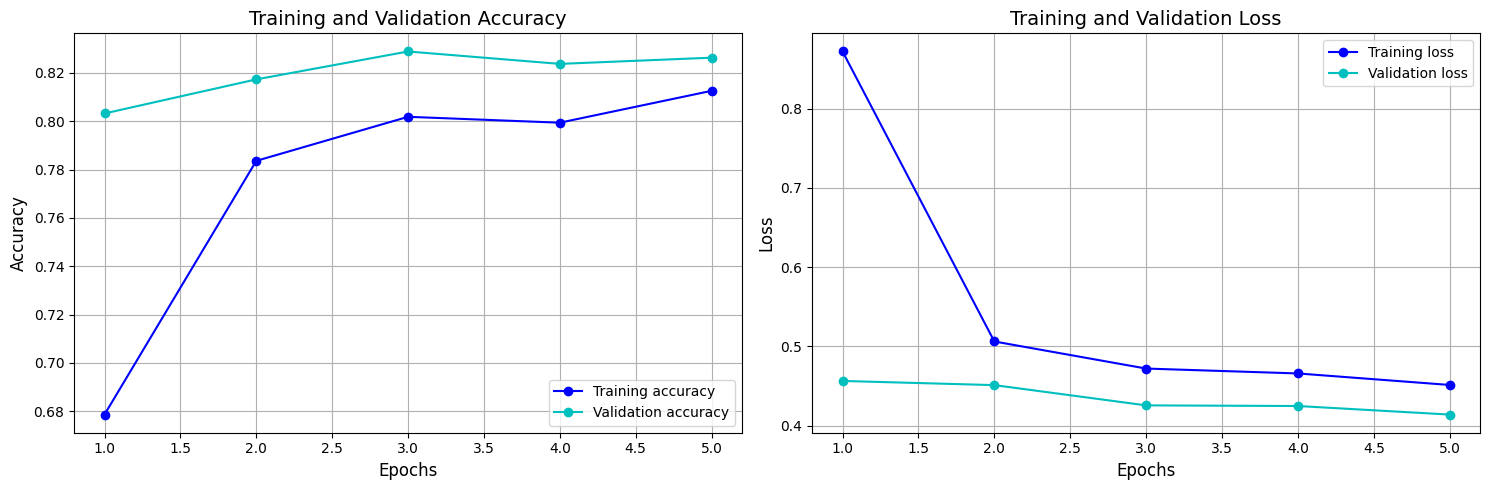

In [ ]:
show_history_plot(history_ResNet.history)

In [ ]:
evaluation_matrix(ResNet_model)

             Loss       Accuracy  
----------------------------------
Train        0.40963    0.83250   
Validation   0.41025    0.82864   
Test         0.42747    0.82625   


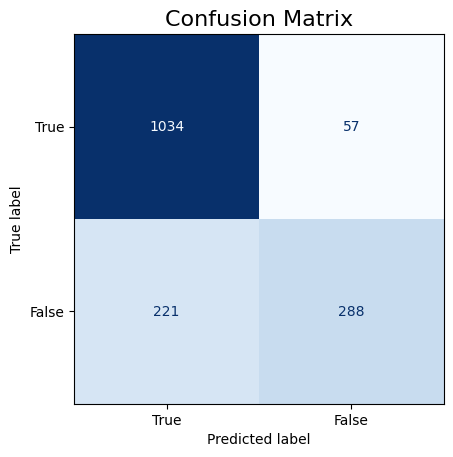

<Figure size 700x700 with 0 Axes>

In [ ]:
show_conf_matrix(ResNet_model)

In [ ]:
final_validation_accuracy = history_ResNet.history['val_accuracy'][-1]
def index(final_validation_accuracy):
    # Calculate accuracy
   

    # Render HTML template with accuracy
    return render_template('1.html', accuracy=final_validation_accuracy)

if __name__ == '__main__':
    app.run(debug=True)